# Actual stuff

Launch two terminals from the main tree.

In [1]:
# get some basic os functions
import os
import glob
# import our parallel processing framework
import dask
import dask.multiprocessing
from dask.diagnostics import ProgressBar
import distributed
from distributed.diagnostics import progress
# numpy and plotting
import numpy as np
from itertools import accumulate
from operator import matmul
%matplotlib inline
import matplotlib.pyplot as plt
# image reading and writing
from skimage.external import tifffile as tif
#
import seaborn as sns
# load our actual registration functions
from imreg_dph import *
# monkey patch in numpy's fft, pyfftw doesn't play nice with the cluster
import imreg_dph
imreg_dph.fft2 = np.fft.fft2
imreg_dph.ifft2 = np.fft.ifft2
imreg_dph.fftshift = np.fft.fftshift

In [2]:
import bokeh.plotting as bp
bp.output_notebook()

Loading BokehJS ...

if running on the cluster we need to start our scheduler:

    dask-scheduler --scheduler-file /groups/betzig/home/hoffmand/dask-scheduler.json

this should be done on the same computer that's running this notebook (not windows, use login1 or login2 or
 a qlogin interactive session on the cluster)
 
You can now open up a status window [http://[all ip addresses on host]:8787](http://localhost:8787)

```
# if running on cluster we need to start our workers
START "" /B dask-scheduler --scheduler-file "dask\dask-scheduler.json" > "test.txt"
START "" /B dask-worker --scheduler-file "dask\dask-scheduler.json" > "test2.txt"
```

In [3]:
# if running on the cluster we need to attached to the scheduler
client = distributed.Client(scheduler_file="dask/dask-scheduler.json")
client

<Client: scheduler='tcp://10.102.20.83:8786' processes=1 cores=48>

# Dask array dev

In [4]:
from fibsem import readfibsem

In [5]:
from dask import delayed

@delayed(pure=True)
def lazy_imread(path):
    """Return inlens data as array"""
    return np.asarray(readfibsem(path)[0])

def make_lazy_data(paths):
    lazy_data = [lazy_imread(path) for path in paths]
    sample = lazy_data[0].compute()
    data = [dask.array.from_delayed(ld, shape=sample.shape, dtype=sample.dtype) for ld in lazy_data]
    data_array = dask.array.stack(data)
    return data_array

In [6]:
paths = sorted(glob.glob(r"\\hess-nas10\share\nVision Data backup02012017\Cryo\Y2017\M01\D19\*.dat"))
len(paths)

505

In [7]:
client.upload_file("fibsem.py")

In [8]:
raw_stack = make_lazy_data(paths)

In [9]:
raw_stack

dask.array<stack, shape=(505, 1500, 18750), dtype=uint8, chunksize=(1, 1500, 18750)>

In [10]:
nz, ny, nx = raw_stack.shape
raw_stack = raw_stack.rechunk((nz // os.cpu_count(), ny, nx))

In [11]:
raw_stack[0]

dask.array<getitem, shape=(1500, 18750), dtype=uint8, chunksize=(1500, 18750)>

In [12]:
%time raw_stack = client.persist(raw_stack)
client.processing()

Wall time: 82.1 ms


{'tcp://10.102.20.83:54068': {"('from-value-lazy_imread-stack-rechunk-split-ba290f2c577bd60eb0c2765518ccd3d3', 0)",
  "('from-value-lazy_imread-stack-rechunk-split-ba290f2c577bd60eb0c2765518ccd3d3', 1)",
  "('from-value-lazy_imread-stack-rechunk-split-ba290f2c577bd60eb0c2765518ccd3d3', 10)",
  "('from-value-lazy_imread-stack-rechunk-split-ba290f2c577bd60eb0c2765518ccd3d3', 100)",
  "('from-value-lazy_imread-stack-rechunk-split-ba290f2c577bd60eb0c2765518ccd3d3', 101)",
  "('from-value-lazy_imread-stack-rechunk-split-ba290f2c577bd60eb0c2765518ccd3d3', 102)",
  "('from-value-lazy_imread-stack-rechunk-split-ba290f2c577bd60eb0c2765518ccd3d3', 103)",
  "('from-value-lazy_imread-stack-rechunk-split-ba290f2c577bd60eb0c2765518ccd3d3', 104)",
  "('from-value-lazy_imread-stack-rechunk-split-ba290f2c577bd60eb0c2765518ccd3d3', 105)",
  "('from-value-lazy_imread-stack-rechunk-split-ba290f2c577bd60eb0c2765518ccd3d3', 106)",
  "('from-value-lazy_imread-stack-rechunk-split-ba290f2c577bd60eb0c2765518ccd

In [29]:
client.processing()

{'tcp://10.102.20.83:54068': set()}

In [30]:
import bokeh.models

In [31]:
import bokeh.driving

In [32]:
from datashader.bokeh_ext import InteractiveImage
from datashader.transfer_functions import Image
import datashader as ds

C:\Anaconda3\lib\site-packages\odo\backends\pandas.py:94: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


In [34]:
junk =img2Image(raw_stack[0], x_range=[0, 900], y_range=[512, 1024])

In [39]:
type(junk)

datashader.transfer_functions.Image

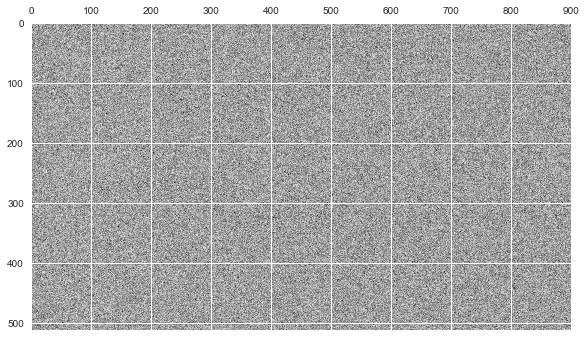

In [35]:
plt.matshow(img2Image(raw_stack[0], x_range=[0, 900], y_range=[512, 1024]))

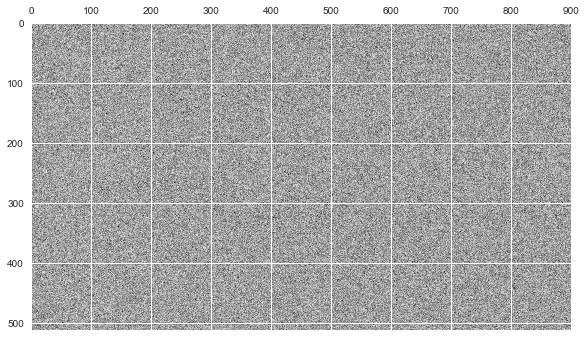

In [36]:
plt.matshow(raw_stack[0][slice(*[512, 1024]), slice(*[0, 900])])

In [43]:
import PIL

In [48]:
junk2 = junk.to_pil()

In [50]:
type(junk2)

PIL.Image.Image

In [63]:
junk = np.random.randint(255, size=raw_stack[0].shape, dtype=np.uint8)

In [58]:
def img2Image(img, x_range, y_range):
    # need to normalize range here
    yy, xx = np.arange(*y_range), np.arange(*x_range)
    raw = img[slice(*y_range), slice(*x_range)]
    print(raw.shape)
    new = np.dstack([raw, raw, raw, np.ones_like(raw) * 255]).view(np.uint32).reshape(raw.shape)
    return Image(new, coords={"y_axis": yy, "x_axis": xx}, dims=("y_axis", "x_axis"))

In [62]:
junk.dtype

dtype('int32')

In [64]:
raw_stack.shape

(505, 1500, 18750)

In [65]:
plot = bp.figure(plot_width=900, plot_height=512,
                 x_range=[900, 1800], y_range=[512, 1024])

def create_image(x_range, y_range, w, h):
    print(x_range)
    return img2Image(junk, x_range, y_range)

InteractiveImage(plot, create_image, delay=1)

(900, 1800)
(512, 900)
